In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from pyntcloud import PyntCloud
from pyquaternion import Quaternion
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import transform_matrix, view_points
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

In [2]:
dataset_path = 'D:\\Virtual Machines\\shared\\3d-object-detection-for-autonomous-vehicles\\'
dataset = LyftDataset(data_path=dataset_path, json_path=dataset_path + 'data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 11.5 seconds.
Reverse indexing ...
Done reverse indexing in 3.1 seconds.


In [3]:
cams = [
    'CAM_FRONT',
    'CAM_FRONT_LEFT',
    'CAM_FRONT_RIGHT',
    'CAM_BACK',
    'CAM_BACK_LEFT',
    'CAM_BACK_RIGHT'
]

In [4]:
scene = dataset.scene[0]

sample_token = scene['first_sample_token']
sample = dataset.get('sample', sample_token)

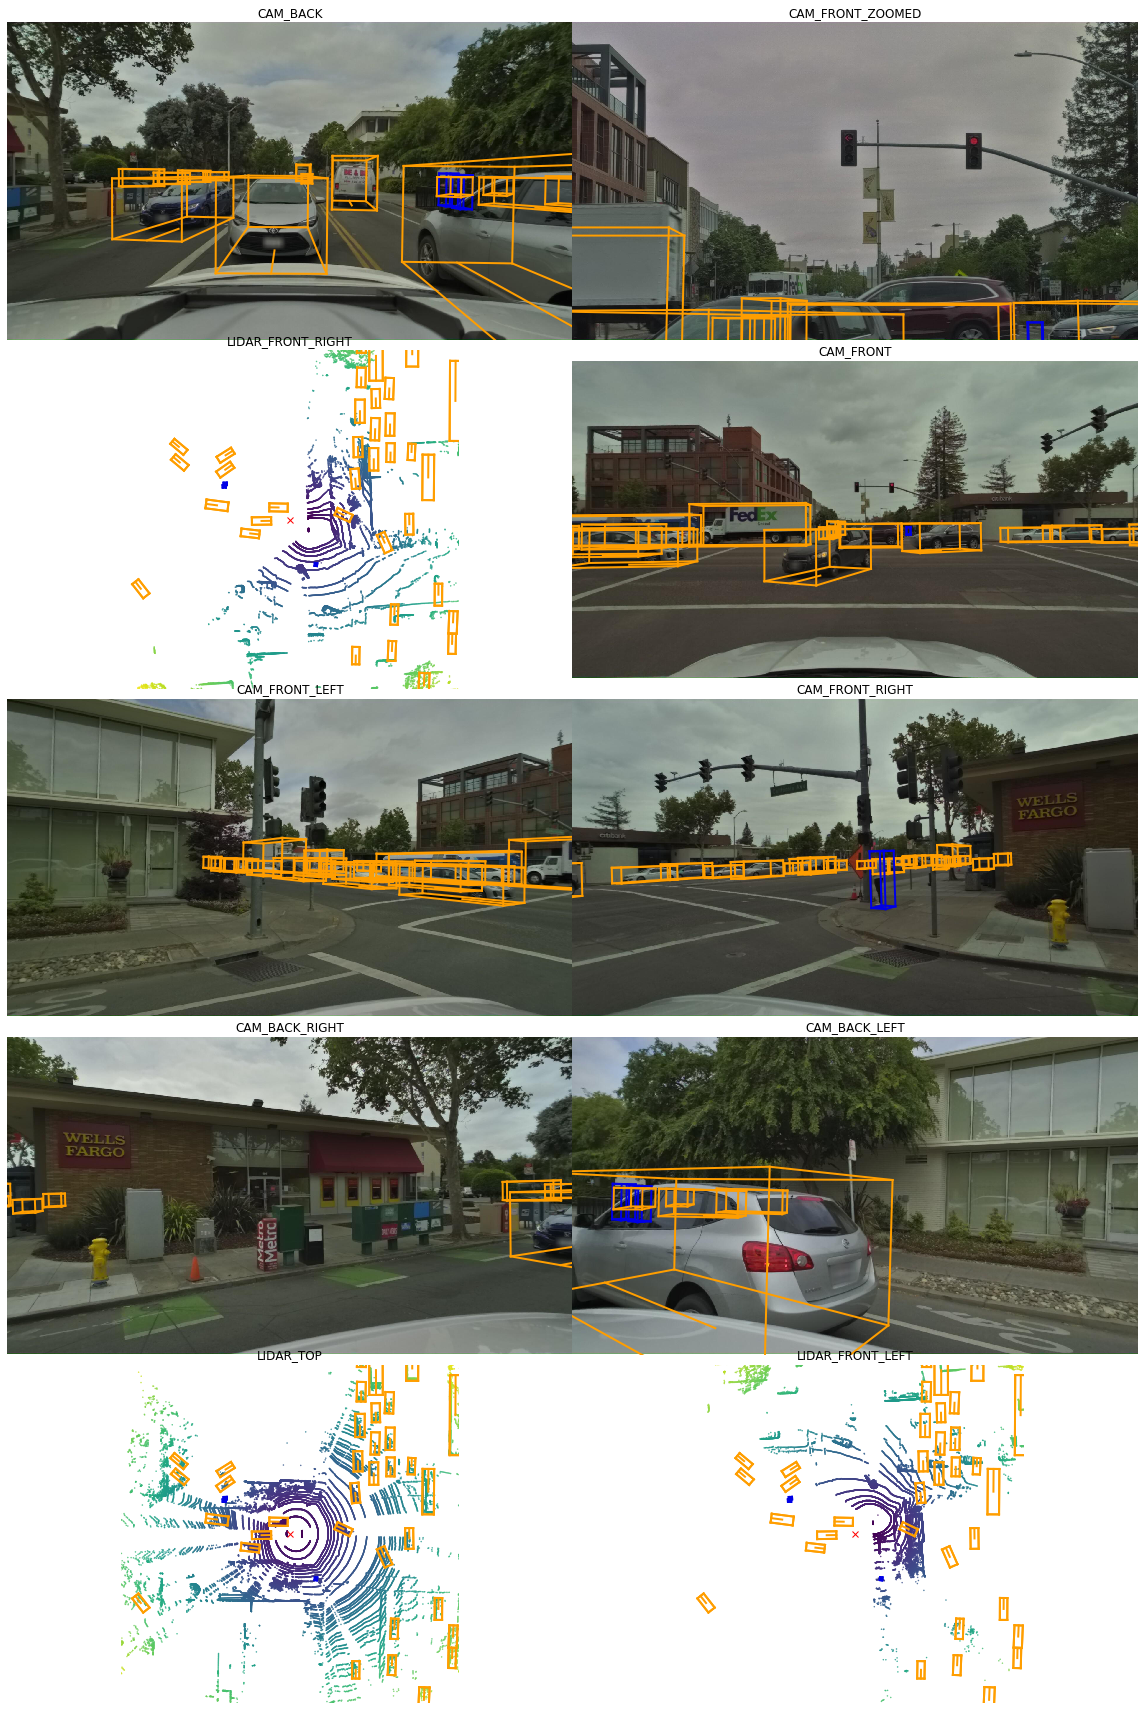

In [5]:
dataset.render_sample(sample_token)

In [24]:
sd_lidar = dataset.get('sample_data', sample['data']['LIDAR_TOP'])
cs_lidar = dataset.get('calibrated_sensor', sd_lidar['calibrated_sensor_token'])

pc = LidarPointCloud.from_file(dataset.data_path / sd_lidar['filename'])
pc.points.shape

(4, 107845)

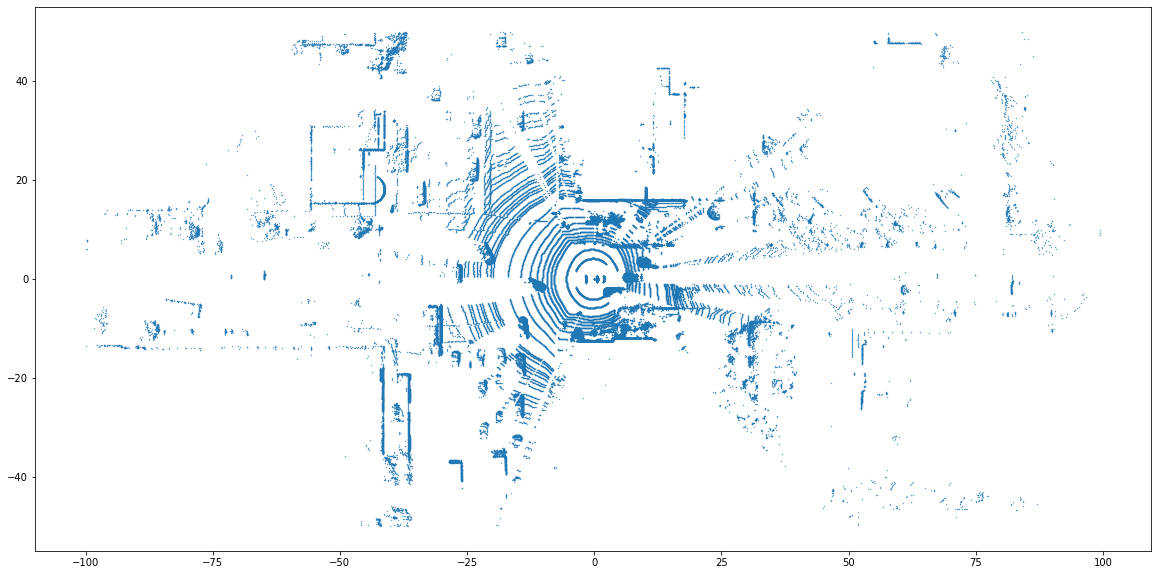

In [165]:
orig_pc = np.swapaxes(pc.points, 0, 1)
orig_pc = orig_pc[(orig_pc[:, 0] >= -100) & 
                  (orig_pc[:, 0] <= 100) & 
                  (orig_pc[:, 1] >= -50) & 
                  (orig_pc[:, 1] <= 50)]

# left is the front
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(orig_pc[:, 0], orig_pc[:, 1], s=0.1)

In [202]:
cam = 'CAM_BACK'
cam_token = sample['data'][cam]
sd_cam = dataset.get('sample_data', cam_token)
cs_cam = dataset.get('calibrated_sensor', sd_cam['calibrated_sensor_token'])

height = sd_cam['height']
width = sd_cam['width']
img_size = (width, height)

lidar_2_ego = transform_matrix(
    cs_lidar['translation'],
    Quaternion(cs_lidar['rotation']),
    inverse=False
)

"""
ego_pose = dataset.get('ego_pose', sd_lidar['ego_pose_token'])
ego_2_global = transform_matrix(
    ego_pose['translation'],
    Quaternion(ego_pose['rotation']),    
    inverse=False
)

ego_pose = dataset.get('ego_pose', sd_cam['ego_pose_token'])
global_2_ego = transform_matrix(
    ego_pose['translation'],
    Quaternion(ego_pose['rotation']),
    inverse=True
)
"""

ego_2_cam = transform_matrix(
    cs_cam['translation'],
    Quaternion(cs_cam['rotation']),
    inverse=True
)

ninety = transform_matrix(
    [0, 0, 0],
    Quaternion(axis=(1, 0, 0), angle=np.pi/2),
    inverse=True
)

lidar_2_cam = ninety @ ego_2_cam @ lidar_2_ego
#lidar_2_cam = lidar_2_ego

In [203]:
xlimit = (0, 70)
ylimit = (-40, 40)

points = view_points(pc.points[:3, :], lidar_2_cam, normalize=False)

# (3, N) to (N, 3)
points = np.swapaxes(points, 0, 1)
cropped_points = points[(points[:, 0] >= xlimit[0]) & 
                        (points[:, 0] <= xlimit[1]) & 
                        (points[:, 1] >= ylimit[0]) & 
                        (points[:, 1] <= ylimit[1])]

df = pd.DataFrame(cropped_points, columns=['x', 'y', 'z'])
df.describe()

,x,y,z
count,50772.000000,50772.000000,50772.000000
mean,10.057583,-2.242600,-0.470243
std,7.577577,14.615153,1.037061
min,0.000094,-39.999814,-5.214826
25%,3.881509,-10.548456,-1.200331
50%,10.255150,0.445094,-0.468926
75%,12.489537,4.622220,0.051110
max,69.252790,39.983347,7.607555


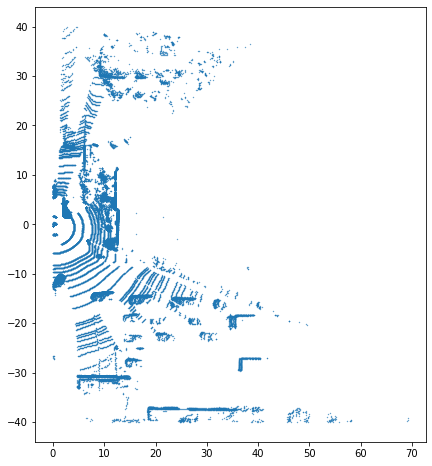

In [204]:
_, ax = plt.subplots(1, 1, figsize=(7, 8))
ax.scatter(cropped_points[:, 0], cropped_points[:, 1], s=0.1)

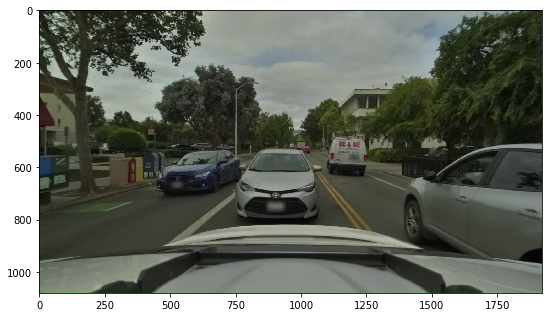

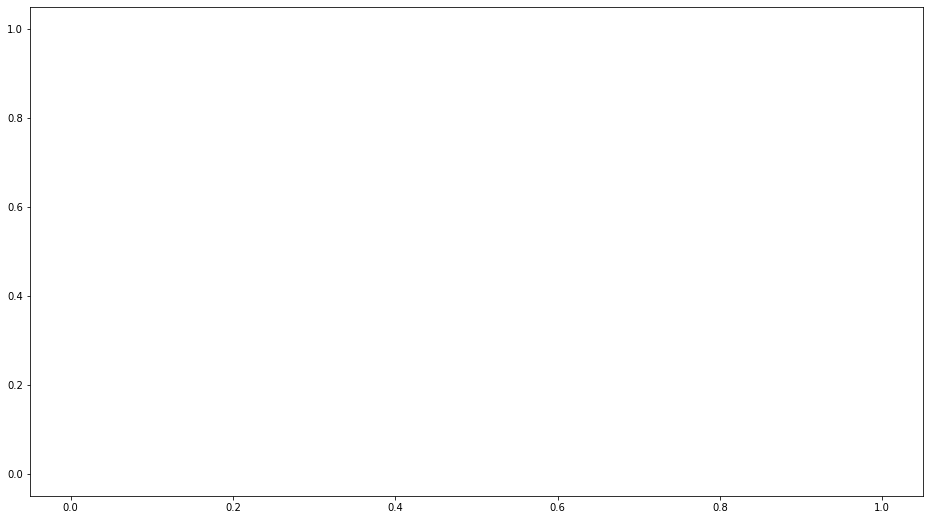

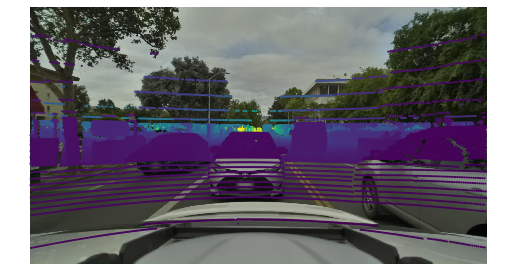

In [129]:
cam_points = view_points(pc.points[:3, :], lidar_2_cam, normalize=False)

depths = cam_points[2, :]

cam_points = view_points(cam_points[:3, :], np.array(cs_cam["camera_intrinsic"]), normalize=True)

img = Image.open(dataset.data_path / sd_cam['filename'])

mask = np.ones(depths.shape[0], dtype=bool)
mask = np.logical_and(mask, depths > 0)
mask = np.logical_and(mask, cam_points[0, :] > 1)
mask = np.logical_and(mask, cam_points[0, :] < img_size[0] - 1)
mask = np.logical_and(mask, cam_points[1, :] > 1)
mask = np.logical_and(mask, cam_points[1, :] < img_size[1] - 1)
cam_points = cam_points[:, mask]


plt.figure(figsize=(9, 16))
plt.imshow(img)
plt.scatter(cam_points[0, :], cam_points[1, :], c=depths[mask], s=0.2)

_, ax = plt.subplots(1,1, figsize=(16, 9))
ax.scatter(cam_points[0, :], cam_points[1, :], c=depths[mask], s=2)

dataset.render_pointcloud_in_image(sample_token=sample_token,
                                      dot_size=1,
                                      camera_channel=cam)

In [84]:
cloud = PyntCloud(df)
cloud.plot()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(16.04923586713975, 40.24600762551101, 17.195…

In [13]:
voxelgrid_id = cloud.add_structure("voxelgrid", n_x=512, n_y=448, n_z=32)
voxelgrid = cloud.structures[voxelgrid_id]

In [14]:
z_max = voxelgrid.get_feature_vector(mode='z_max')
z_max.shape

(512, 448, 32)

In [15]:
highest = np.apply_along_axis(np.amax, 2, z_max)
highest.shape

(512, 448)

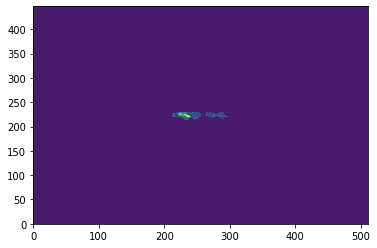

In [16]:
x_ = np.arange(512)
y_ = np.arange(448)

X, Y = np.meshgrid(x_, y_)
Z = np.swapaxes(highest, 0, 1)

_, ax = plt.subplots(1, 1)
ax.contourf(X, Y, Z)